**420-A52-SF - Algorithmes d'apprentissage supervisé - Automne 2022 - Spécialisation technique en Intelligence Artificielle**<br/>
MIT License - Copyright (c) 2022 Mikaël Swawola
<br/>
![Travaux Pratiques - Régularisation](static/12-A1-banner.png)
<br/>
**Objectif:** cette séance de travaux pratiques a pour objectif la mise en oeuvre des régularisations de Tikhonov, Lasso et ElasticNet sur le jeu de données **Credit**

In [153]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### 1 - Chargement et exploration sommaire des données

**Charger et visualiser le jeu de données Credit**

In [154]:
# Manipulation de données
import numpy as np
import pandas as pd

# Visualisation de données
import matplotlib.pyplot as plt
import seaborn as sns

# Helpers pour l'affichage
#from helpers import plot_classifier

# Outils divers
from tqdm import tqdm
from collections import defaultdict

# Machine Learning
# Compléter l'importation des modules scikit-learn requis au fur et à mesure de l'atelier
from sklearn.model_selection import train_test_split

# Configuration de la visualisation
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

### 2 - Préparation des données

**Préparer le données afin de pouvoir les utiliser dans nos modèles**

In [155]:
# Compléter le code ci-dessous ~ 1-2 lignes
df = pd.read_csv("../../data/Credit.csv", index_col=0)
df.describe()

,Income,Limit,Rating,Cards,Age,Education,Balance
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,45.218885,4735.600000,354.940000,2.957500,55.667500,13.450000,520.015000
std,35.244273,2308.198848,154.724143,1.371275,17.249807,3.125207,459.758877
min,10.354000,855.000000,93.000000,1.000000,23.000000,5.000000,0.000000
25%,21.007250,3088.000000,247.250000,2.000000,41.750000,11.000000,68.750000
50%,33.115500,4622.500000,344.000000,3.000000,56.000000,14.000000,459.500000
75%,57.470750,5872.750000,437.250000,4.000000,70.000000,16.000000,863.000000
max,186.634000,13913.000000,982.000000,9.000000,98.000000,20.000000,1999.000000


In [28]:
df.dtypes

Limit         int64
Rating        int64
Cards         int64
Age           int64
Education     int64
Gender       object
Student      object
Married      object
Balance       int64
dtype: object

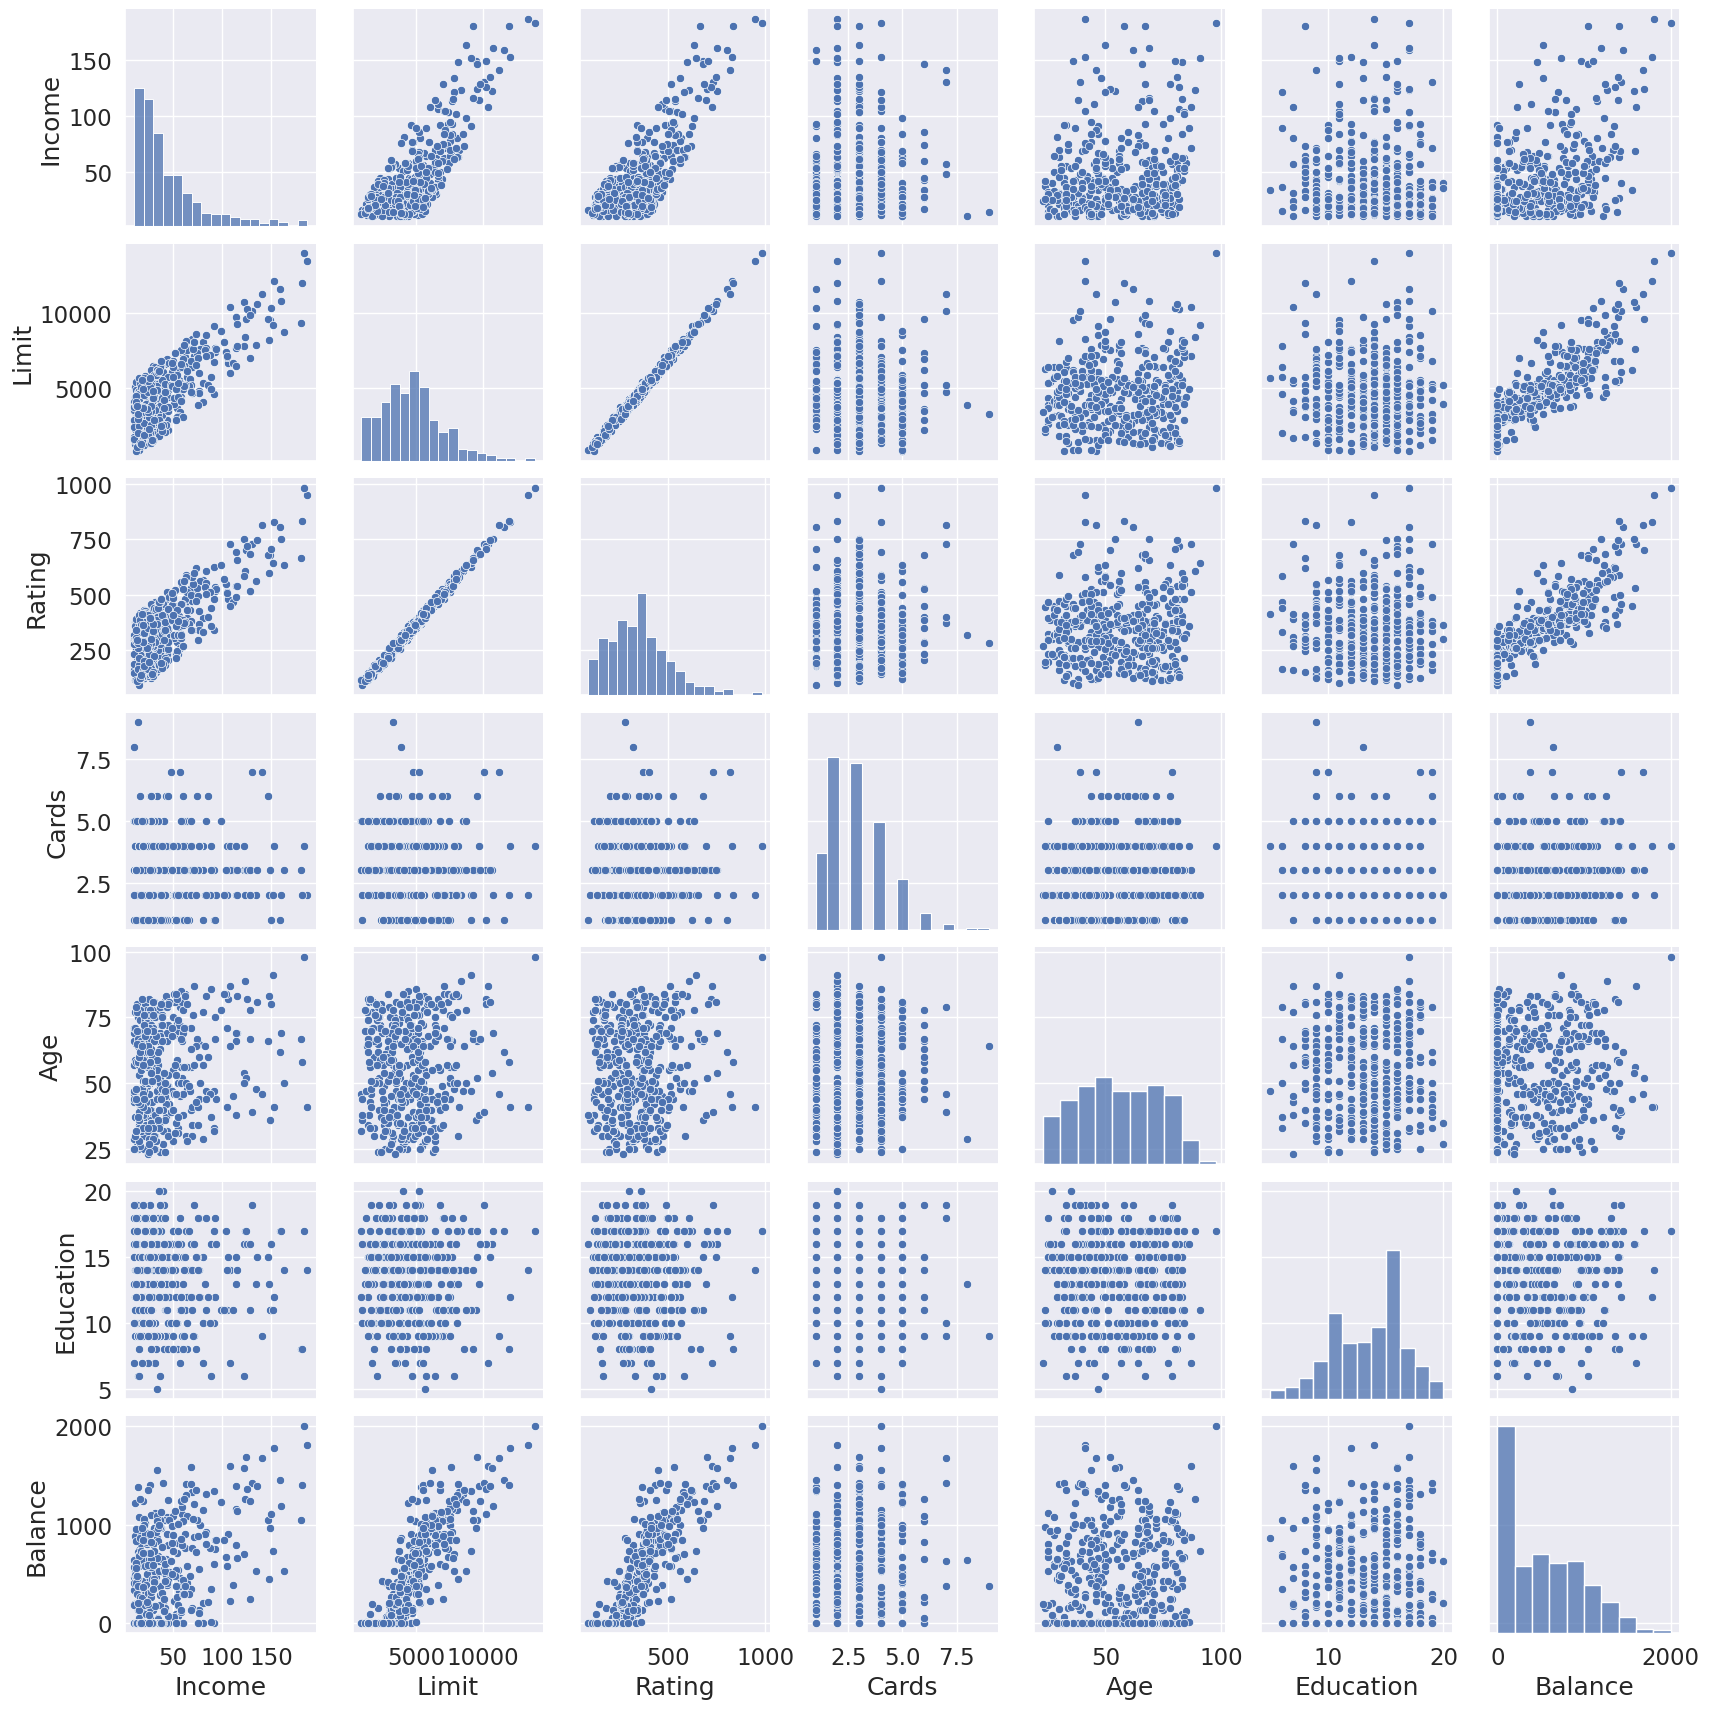

In [129]:
sns.pairplot(df)

In [196]:
dfY = df["Balance"]
dfX =  df.drop("Balance", axis=1)
#dfX = df = df.loc[:, ~df.columns.str.contains('^Unnamed')].copy()
#HRT_numerique = pd.get_dummies(data=HRT, columns = lstCol, drop_first=True, prefix=lstCol).copy()
lstCols = ["Gender", "Student", "Married"]
dfX_numerique = pd.get_dummies(data = dfX, columns = lstCols, drop_first=True, prefix=lstCols)

In [197]:
dfX.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married
1,14.891,3606,283,2,34,11,Male,No,Yes
2,106.025,6645,483,3,82,15,Female,Yes,Yes
3,104.593,7075,514,4,71,11,Male,No,No
4,148.924,9504,681,3,36,11,Female,No,No
5,55.882,4897,357,2,68,16,Male,No,Yes


In [160]:
dfX_numerique.columns.values


array(['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education',
       'Gender_Male', 'Student_Yes', 'Married_Yes'], dtype=object)

In [169]:
### ajout var polynomiales pour forcer overfitting
#X_poly = np.c_[dfX_numerique.values, dfX_numerique.values[:, 6]**2
#, dfX_numerique.values[:, 6]**3
#, dfX_numerique.values[:, 6]**4
#, dfX_numerique.values[:, 6]**5
#, dfX_numerique.values[:, 6]**6 ]

colIndex =5
X_poly = np.c_[dfX_numerique.values, dfX_numerique.values[:, colIndex]**2
, dfX_numerique.values[:, colIndex]**3
, dfX_numerique.values[:, colIndex]**4
, dfX_numerique.values[:, colIndex]**5
, dfX_numerique.values[:, colIndex]**6 ]

#colName = 'Limit'
#X_poly = np.c_[dfX_numerique.values, dfX_numerique.values[:, dfX_numerique[colName]]**2
#, dfX_numerique.values[:, dfX_numerique[colName]]**3
#, dfX_numerique.values[:, dfX_numerique[colName]]**4
#, dfX_numerique.values[:, dfX_numerique[colName]]**5
#, dfX_numerique.values[:, dfX_numerique[colName]]**6 ]

In [212]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
dfXPoly = poly.fit_transform(dfX_numerique)

In [170]:
#dfX_numerique.shape
X_poly.shape

(400, 14)

In [171]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_poly)
X_scale = scaler.transform(X_poly)

### 3 - Séparation des données train / test

[ sklearn.model_selection.train_test_split(*arrays, **options)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

**Garder 20% des données pour le test**

In [172]:
# Compléter le code ci-dessous ~ 2 lignes
#X_train, X_test, y_train, y_test = train_test_split(dfX_numerique,dfY, shuffle=True, test_size=0.50, random_state=2020)
X_train, X_test, y_train, y_test = train_test_split(X_scale,dfY, shuffle=True, test_size=0.20, random_state=2020)

### 4 - Régression linéaire

[class sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [144]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import metrics

In [217]:
def eval_linear_regression(pDfX
, pDfY
, pDescription=""
, nbDecimal=3
, pModel = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None)
, pTestSize=0.2):
    print("------------------")
    print("[pDescription]: ", pDescription)
    print("------------------")
    X_train, X_test, y_train, y_test = train_test_split(pDfX, pDfY, test_size=pTestSize, random_state=0, shuffle=True)
       
    
    #regressor = LinearRegression()
    pModel.fit(X_train, y_train)
    y_train_pred = pModel.predict(X_train)
    RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    print("[RMSE_train]: ", RMSE_train)

    y_test_pred  = pModel.predict(X_test)
    RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print("[RMSE_test]: ", RMSE_test)
        

    #To retrieve the intercept:
    print("[Intercept]: ")
    print(round(pModel.intercept_, nbDecimal))

    #For retrieving the slope:
    #print("[Coefficients]")
    #print(list(zip(pDfX.columns.values, pModel.coef_)))
    
       
    y_pred = pModel.predict(X_test)
    
    #r2 = r2_score(y_test, y_pred)
    
    #df = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred}) 
    
    #p = sns.scatterplot(x=y_test, y=y_pred)
    #p.set_xlabel("predicted")
    #p.set_ylabel("actual")
    
    ## Draw a line of x=y 
    #x0, x1 = g.ax_joint.get_xlim()
    #y0, y1 = g.ax_joint.get_ylim()
    #lims = [max(x0, y0), min(x1, y1)]   
    

    
    print('Mean Absolute Error - [MAE]:', round(metrics.mean_absolute_error(y_test, y_pred), nbDecimal) )  
    print('Mean Squared Error - [MSE]:', round(metrics.mean_squared_error(y_test, y_pred),nbDecimal ) )  
    print('Root Mean Squared Error - [RMSE]:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),nbDecimal) )
    #print('[R2]:', round(r2_score(y_test, y_pred), nbDecimal) )  

In [218]:
pd.DataFrame(X_scale).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.861583,-0.489999,-0.465539,-0.699130,-1.257674,-0.784930,1.035635,-0.333333,0.795395,-0.854208,-0.876818,-0.864517,-0.829353,-0.781287
1,1.727437,0.828261,0.828703,0.031032,1.528451,0.496588,-0.965592,3.000000,0.795395,0.421370,0.329838,0.232719,0.138026,0.051034
2,1.686756,1.014787,1.029311,0.761194,0.889964,-0.784930,1.035635,-0.333333,-1.257237,-0.854208,-0.876818,-0.864517,-0.829353,-0.781287
3,2.946152,2.068440,2.110003,0.031032,-1.141586,-0.784930,-0.965592,-0.333333,-1.257237,-0.854208,-0.876818,-0.864517,-0.829353,-0.781287
4,0.302928,0.070012,0.013331,-0.699130,0.715831,0.816968,1.035635,-0.333333,0.795395,0.801590,0.755473,0.687391,0.605610,0.517126


In [219]:
#eval_linear_regression(dfX_numerique, dfY, pTestSize=0.5)
eval_linear_regression(pd.DataFrame(X_scale), dfY, pTestSize=0.2)
#type(X_scale)

------------------
[pDescription]:  
------------------
[RMSE_train]:  98.85883752790312
[RMSE_test]:  89.84816285190597
[Intercept]: 
518.565
Mean Absolute Error - [MAE]: 69.625
Mean Squared Error - [MSE]: 8072.692
Root Mean Squared Error - [RMSE]: 89.848


In [220]:
eval_linear_regression(dfX_numerique, dfY, pTestSize=0.2)

------------------
[pDescription]:  
------------------
[RMSE_train]:  99.39637341609964
[RMSE_test]:  90.06242932023582
[Intercept]: 
-475.935
Mean Absolute Error - [MAE]: 69.566
Mean Squared Error - [MSE]: 8111.241
Root Mean Squared Error - [RMSE]: 90.062


In [221]:
eval_linear_regression(pd.DataFrame(X_poly), dfY, pTestSize=0.2)

------------------
[pDescription]:  
------------------
[RMSE_train]:  98.85883752790187
[RMSE_test]:  89.84816285190463
[Intercept]: 
3705.483
Mean Absolute Error - [MAE]: 69.625
Mean Squared Error - [MSE]: 8072.692
Root Mean Squared Error - [RMSE]: 89.848


In [222]:
type(dfXPoly)
eval_linear_regression(pd.DataFrame(dfXPoly), dfY, pTestSize=0.2)

------------------
[pDescription]:  
------------------
[RMSE_train]:  69.7692632625144
[RMSE_test]:  91.90197834383494
[Intercept]: 
193899058.596
Mean Absolute Error - [MAE]: 60.989
Mean Squared Error - [MSE]: 8445.974
Root Mean Squared Error - [RMSE]: 91.902


In [223]:
scaler = StandardScaler()
scaler.fit(dfXPoly)
dfX_poly_scale = scaler.transform(dfXPoly)
eval_linear_regression(pd.DataFrame(dfX_poly_scale), dfY, pTestSize=0.2)

------------------
[pDescription]:  
------------------
[RMSE_train]:  49.822170983450846
[RMSE_test]:  61.42545944153829
[Intercept]: 
518.569
Mean Absolute Error - [MAE]: 48.744
Mean Squared Error - [MSE]: 3773.087
Root Mean Squared Error - [RMSE]: 61.425


### 5 - Régularisation de Tikhonov - Ridge Regression

[class sklearn.linear_model.RidgeCV(alphas=(0.1, 1.0, 10.0), fit_intercept=True, normalize=False, scoring=None, cv=None, gcv_mode=None, store_cv_values=False)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)

In [188]:
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(alphas=[0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.12, 0.2, 0.3, 0.5], cv=5).fit(X_train, y_train)
ridge.alpha_

0.2

In [226]:
ridge.coef_

array([ 0.00000000e+00,  2.90969967e+01,  3.24388153e+01,  1.02241707e+02,
        1.05568179e+01,  3.79790569e+01,  9.31199082e+00,  1.30988752e+01,
        1.79870914e+01,  3.63484226e+00,  2.77954067e+02, -4.67010616e+02,
       -5.48590291e+02, -1.48124149e+01,  4.96196435e+01, -4.76871471e+01,
        2.25486114e+01, -3.27174354e+01, -6.87482122e+00,  7.93970361e+02,
        3.00561498e+02,  2.50431085e+01, -1.05768967e+02,  1.19516155e+01,
       -4.14573572e+01,  1.32766679e+02, -6.73384974e+01, -1.48538366e+02,
        1.21290021e+01,  2.46780735e+01,  3.01475913e+01,  1.82522141e+01,
       -1.65551433e+01,  6.89926901e+01,  1.30627081e+01, -3.72432452e+00,
       -8.18008423e+00, -7.65309930e+00,  1.75113784e+00, -1.01875711e+01,
       -2.22633314e+01,  3.78345675e-01, -1.60416867e+01, -1.68490432e+00,
       -2.57904812e+00, -1.76284991e+01,  1.36464164e+00,  2.09173456e+01,
        2.51697852e+00,  1.30988752e+01, -3.21822757e+00, -6.11788460e-01,
        1.79870914e+01, -

In [227]:
X_train, X_test, y_train, y_test = train_test_split(dfX_poly_scale,dfY, shuffle=True, test_size=0.20, random_state=2020)
ridge = RidgeCV(alphas=[0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.12, 0.2, 0.3, 0.5], cv=5).fit(X_train, y_train)
ridge.alpha_

0.04

In [228]:
modele_final = Ridge(alpha=ridge.alpha_, max_iter=1000).fit(X_train, y_train)

In [229]:
## Erro obtido: aprox 50. É melhor do q os da reg linear
y_pred = modele_final.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred))

50.71206958874025

In [ ]:
###Lasso

In [238]:
X_train, X_test, y_train, y_test = train_test_split(dfX_poly_scale,dfY, shuffle=True, test_size=0.20, random_state=2020)
lasso = LassoCV(alphas=[0.01, 0.1,  0.15, 0.2, 0.25, 1000], cv=5,max_iter=100000).fit(X_train, y_train)
lasso.alpha_

0.2

In [242]:
modele_final = Lasso(alpha=lasso.alpha_, max_iter=10000).fit(X_train, y_train)

In [243]:
from sklearn.metrics import mean_squared_error
y_pred = modele_final.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred))

51.82672731574547

In [69]:
# Create a Ridge regressor and compute CV score
# https://github.com/rennyatwork/Machine-Learning-Algorithms-Second-Edition/blob/master/Chapter04/ridge_lasso_elasticnet.py


from sklearn.pipeline import make_pipeline
#model = make_pipeline(StandardScaler(with_mean=False), Ridge())
model = make_pipeline(StandardScaler(with_mean=False), Ridge(0.05, normalize=True))

#rg = Ridge(0.05, normalize=True)
rg_scores = cross_val_score(model, dfX_numerique, dfY, cv=10)
print("--------**************--------")
print('Ridge regression CV average score: %.6f' % rg_scores.mean())
print("--------**************--------")

# Find the optimal alpha value for Ridge regression
rgcv = RidgeCV(alphas=(1.0, 0.1, 0.01, 0.001, 0.005, 0.0025, 0.001, 0.00025), normalize=True)
rgcv.fit(dfX_numerique, dfY)
print("--------**************--------")
print('Ridge optimal alpha: %.3f' % rgcv.alpha_)
print("--------**************--------")

/home/hadoop/.local/lib/python3.11/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
/home/hadoop/.local/lib/python3.11/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

--------**************--------
Ridge regression CV average score: 0.941762
--------**************--------
--------**************--------
Ridge optimal alpha: 0.001
--------**************--------


/home/hadoop/.local/lib/python3.11/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
/home/hadoop/.local/lib/python3.11/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

In [94]:
### gabarito
ridge = RidgeCV(alphas=[0.01, 0.02, 0.05, 0.07, 0.08, 0.09, 0.099, 0.1, 1, 10, 100], cv=5)
ridge.fit(X_train, y_train)
ridge.alpha_

0.1

In [93]:
ridge.coef_

array([-8.07225138e+00,  2.15413009e-01,  7.16718186e-01,  2.09078809e+01,
       -5.20493808e-02, -3.49978756e-01,  1.42102605e+01,  4.12385396e+02,
        5.61603265e-01])

In [103]:
## refaire le fit avec le best alpha
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
modele_final = Ridge(alpha = ridge.alpha_, max_iter=10000).fit(X_train, y_train)

In [104]:
y_pred = modele_final.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred))

99.5023831158088

In [105]:
y_pred = modele_final.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

99.71774922216879

### 6 - Lasso

[class sklearn.linear_model.LassoCV(eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, normalize=False, precompute='auto', max_iter=1000, tol=0.0001, copy_X=True, cv=None, verbose=False, n_jobs=None, positive=False, random_state=None, selection='cyclic')](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)

In [70]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score


from sklearn.pipeline import make_pipeline
#model = make_pipeline(StandardScaler(with_mean=False), Lasso())
model = make_pipeline(StandardScaler(with_mean=False), Lasso(0.01, normalize=True))

# Create a Lasso regressor and compute CV score
#ls = Lasso(0.01, normalize=True)

ls_scores = cross_val_score(model, dfX_numerique, dfY, cv=10)
print("--------**************--------")
print('Lasso regression CV average score: %.6f' % ls_scores.mean())
print("--------**************--------")

# Find the optimal alpha value for Lasso regression
lscv = LassoCV(alphas=(1.0, 0.1, 0.01, 0.001, 0.005, 0.0025, 0.001, 0.00025), normalize=True)
lscv.fit(dfX_numerique, dfY)
print("--------**************--------")
print('Lasso optimal alpha: %.3f' % lscv.alpha_)
print("--------**************--------")

/home/hadoop/.local/lib/python3.11/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/home/hadoop/.local/lib/python3.11/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous 

--------**************--------
Lasso regression CV average score: 0.950307
--------**************--------
--------**************--------
Lasso optimal alpha: 0.010
--------**************--------


/home/hadoop/.local/lib/python3.11/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/home/hadoop/.local/lib/python3.11/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous 

In [122]:
## gabarito
lscv = LassoCV(alphas=(1.0, 0.5,  1.5,2, 3 ,5, 10, 20), cv=5, max_iter=10000)
lscv.fit(X_train, y_train)
lscv.alpha_

1.0

In [123]:
lscv.coef_

array([-8.05878813e+00,  2.12114499e-01,  7.64215736e-01,  2.02220832e+01,
       -6.31644874e-02, -8.93456682e-02,  1.00538338e+01,  4.01281584e+02,
       -0.00000000e+00])

In [125]:
### re-treinar
modele_final = Lasso(alpha=lscv.alpha_, max_iter=10000).fit(X_train, y_train)
#modele_final = Lasso(alpha=[0.9, 1, 1.5], max_iter=1000).fit(X_train, y_train)

In [126]:
## train
y_pred = modele_final.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred))

99.59522007333867

In [127]:
## test
y_pred = modele_final.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

99.93704641214718

### 7 - ElasticNet

[class sklearn.linear_model.ElasticNetCV(l1_ratio=0.5, eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, normalize=False, precompute='auto', max_iter=1000, tol=0.0001, cv=None, copy_X=True, verbose=0, n_jobs=None, positive=False, random_state=None, selection='cyclic')](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html)

In [71]:
# Create ElasticNet regressor and compute CV score

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet(alpha=0.001, l1_ratio=0.8, normalize=True))
en_scores = cross_val_score(model, dfX_numerique, dfY, cv=10)
#en = ElasticNet(alpha=0.001, l1_ratio=0.8, normalize=True)
#en_scores = cross_val_score(en, dfX_numerique, dfY, cv=10)
print("--------**************--------")
print('ElasticNet regression CV average score: %.6f' % en_scores.mean())
print("--------**************--------")

# Find the optimal alpha and l1_ratio for Elastic Net
encv = ElasticNetCV(alphas=(0.1, 0.01, 0.005, 0.0025, 0.001), l1_ratio=(0.1, 0.25, 0.5, 0.75, 0.8), normalize=True)
encv.fit(dfX_numerique, dfY)
print("--------**************--------")
print('ElasticNet optimal alpha: %.3f and L1 ratio: %.4f' % (encv.alpha_, encv.l1_ratio_))
print("--------**************--------")

/home/hadoop/.local/lib/python3.11/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(
/home/hadoop/.local/lib/python3.11/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will b

--------**************--------
ElasticNet regression CV average score: 0.934980
--------**************--------
ElasticNet optimal alpha: 0.001 and L1 ratio: 0.8000


/home/hadoop/.local/lib/python3.11/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.
  warnings.warn(


In [ ]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('scale', StandardScaler()), 
    ('reduce_dims')

])